# Table of Contents
 <p><div class="lev1"><a href="#Escletxes-verticals"><span class="toc-item-num">1&nbsp;&nbsp;</span>Escletxes verticals</a></div><div class="lev2"><a href="#Extracció-de-les-dades"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Extracció de les dades</a></div><div class="lev3"><a href="#Carreguem-les-dades"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Carreguem les dades</a></div><div class="lev3"><a href="#Càlcul-dels-màxims-en-les-imatges"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Càlcul dels màxims en les imatges</a></div><div class="lev3"><a href="#Separació-dels-màxims-en-les-imartges"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Separació dels màxims en les imartges</a></div><div class="lev3"><a href="#Càcul-de-les-distàncies-entre-pics-(en-píxels)"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Càcul de les distàncies entre pics (en píxels)</a></div><div class="lev3"><a href="#Transformació-de-les-dades-a-mm"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Transformació de les dades a mm</a></div><div class="lev2"><a href="#Anàlisi-de-les-dades-obtingudes"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Anàlisi de les dades obtingudes</a></div><div class="lev1"><a href="#Anàlisi-d'imatges"><span class="toc-item-num">2&nbsp;&nbsp;</span>Anàlisi d'imatges</a></div><div class="lev2"><a href="#Anàlisi-de-la-forma-dels-pics-d'intensitat"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Anàlisi de la forma dels pics d'intensitat</a></div><div class="lev2"><a href="#Anàlisi-de-la-xarxa-hexagonal"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Anàlisi de la xarxa hexagonal</a></div>

In [158]:
import IPython.display as Display
from IPython.display import Latex
%matplotlib inline
%run ../starter.py
from PIL import Image
from scipy import signal as sig
import matplotlib.lines as mlines
from matplotlib.colors import LogNorm

# Escletxes verticals

Estudi de les interferències fetes per una - o mútliples - escletxes verticals.


## Extracció de les dades

### Carreguem les dades

Hem fet fotografies als papers milimetrats on hem pres les dades. A partir de les fotografies captarem els màxims, i podrem fer les mesures pertinents. Començem carregant les coordenades en la imatge dels papers milimetrats de les dades preses:

In [159]:
data = pd.read_csv("IN/CSV/positions.dat", sep="\t")
data["edges"] = [((X0,Y0),(X1,Y1)) 
                 for X0,Y0,X1,Y1 in
                   zip(data['X0'],data['Y0'],
                       data['X1'],data['Y1'],)]
data

IMG   X0   Y0    X1    Y1  N  Size    Sep                      edges
0     2  237   50  1556   192  1  0.02  0.000   ((237, 50), (1556, 192))
1     2  108  318  1556   409  1  0.04  0.000  ((108, 318), (1556, 409))
2     2   93  460  1591   503  1  0.08  0.000   ((93, 460), (1591, 503))
3     2   51  513  1591   594  1  0.16  0.000   ((51, 513), (1591, 594))
4     2   51  630  1591   768  1  0.00  0.000   ((51, 630), (1591, 768))
5     1  200  138  1566   290  2  0.08  0.260  ((200, 138), (1566, 290))
6     1  394  326  1245   428  2  0.08  0.500  ((394, 326), (1245, 428))
7     1  204  498  1522   570  2  0.04  0.125  ((204, 498), (1522, 570))
8     2   51  777  1591   862  2  0.04  0.250   ((51, 777), (1591, 862))
9     2   51  900  1591  1070  2  0.04  0.500  ((51, 900), (1591, 1070))
10    1  324  674  1534   744  3  0.04  0.250  ((324, 674), (1534, 744))

In [160]:
no_secondary_images = data[data["N"]==1]
secondary_images = data[data["N"]>1]

Imatges preses que estudiarem:

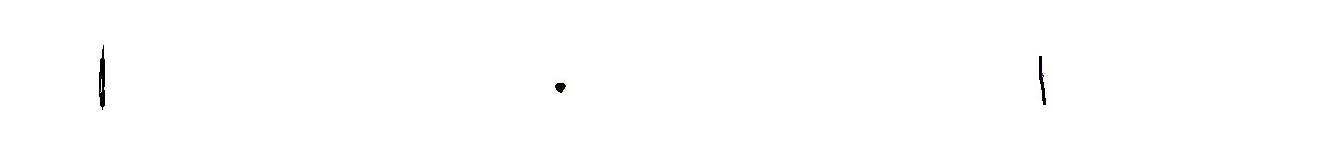

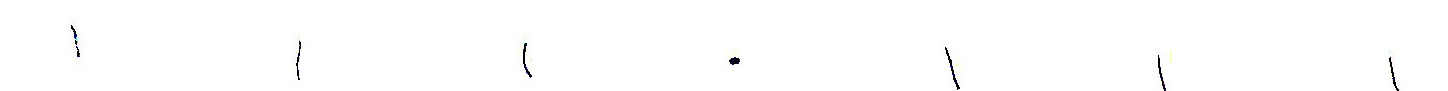

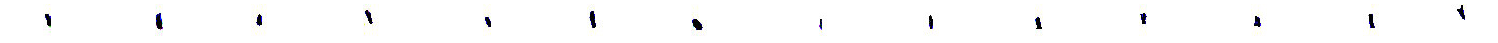

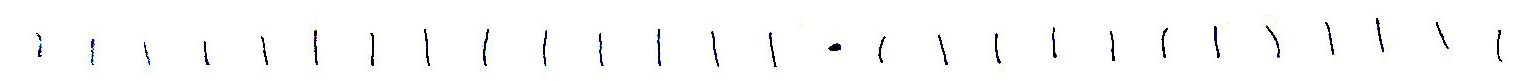

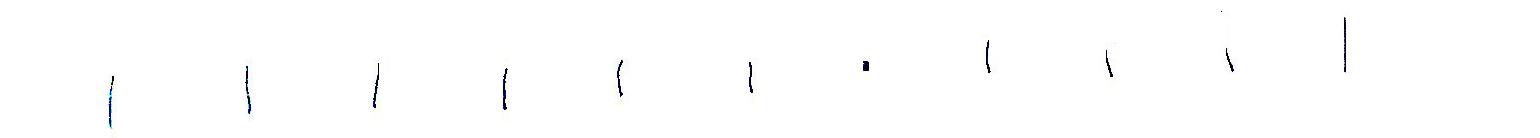

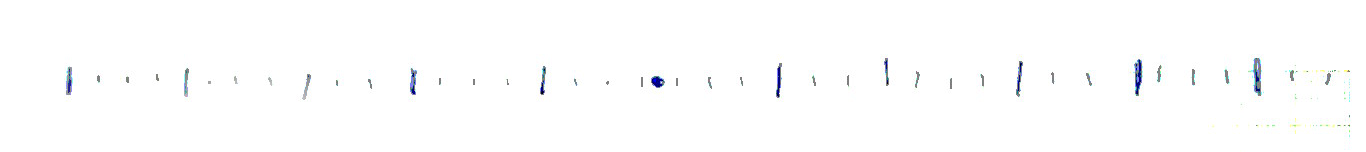

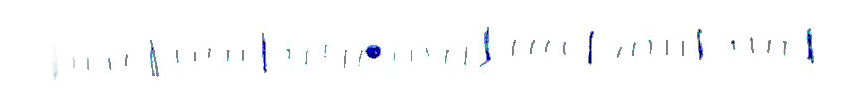

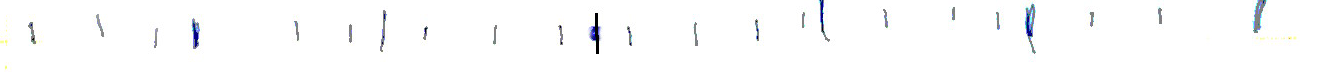

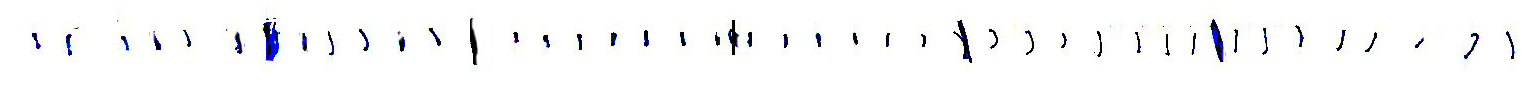

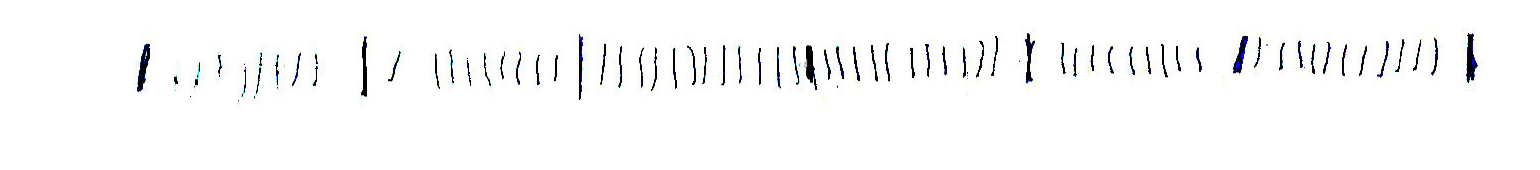

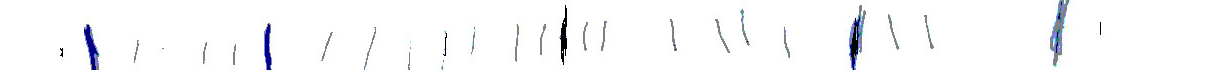

In [161]:
from io import BytesIO
for im, edges in zip(data['IMG'],data['edges']):
    im = load_subImage(im, edges,"IN/IMG/im0{}.jpg")
    im = Image.fromarray(im)
    bio = BytesIO()
    im.save(bio, format='png')
    Display.display(
        Display.Image(bio.getvalue(), format='png'))

Ara que tenim les coordenades, podem construir una funció que ens permeti llegir les imatges, i extreure'n les dades:

In [162]:
def load_subImage(imNum, coords,imName = "IN/IMG/im0{}.jpg"):
    img = Image.open(imName.format(imNum))
    img = np.asarray(img)
    return img[coords[0][1]:coords[1][1],
               coords[0][0]:coords[1][0],:]

Un exemple de les imatges fetes podria ser la següent:

{{Image.fromarray(load_subImage(secondary_images['IMG'][8],secondary_images['edges'][8],imName = "IN/IMG/0{}.jpg"))}}.


<center> 
Les barres més gruixudes indiquen els zeros de la ona moduladora, i les barres més primes els zeros de la ona modulada </center>

Ara ens interessaria calcular de forma automàtica la posició dels màxims en les imatges.

### Càlcul dels màxims en les imatges

Com es pot observar, les imatges tenen molt de soroll, per tant cal filtrar les imatges (qualsevol programa d'edició d'imatges de propòsit general aniria bé). Un cop correctament filtrada, la imatge es transforma en:

{{Image.fromarray(load_subImage(secondary_images['IMG'][8],secondary_images['edges'][8],imName = "IN/IMG/im0{}.jpg"))}}.

Per a trobar les barres de la figura, utilitzarem el següent algoritme:

* Projectar la imatge sobre l'eix de les X: Sumar totes les columnes de píxels en l'eix Y. Així obtindrem una tira 1-dimensional de nombres. El valor d'aquesta tira ens ha de permetre detectar els punts més foscos de la imatge.

* Filtrar la sèrie obtinguda de dades, ja que tindrà molt soroll.

* Detectar els màxims obtinguts després del filtre

La següent funció implementa aquest algoritme:

In [163]:
def find_maximum(img, N=5, M=35, pc=75):
    #Projecció
    lkh = (255-img[:,:,2]).sum(axis=0)
    
    #filtre
    smooth1 = np.convolve(lkh, np.ones((N,))/N, mode='same')
    smooth2 = sig.medfilt(lkh, M)
    smooth =(smooth1-smooth2)[25:-25]

    #detecció de màxims
    sel1 = (np.diff(smooth,1)[:-1]>0)&(np.diff(smooth,1)[1:]<=0)
    sel2 = np.percentile(smooth, pc) < smooth[1:-1]
    mx = sel1&sel2

    return mx, smooth

Provem per tant, d'aplicar aquest algoritme a les dades donades. Posem dos exemples dels resultats, un per al cas en que hem marcat els zeros de la ona moduladora, i un per al cas en que no hi havia ona moduladora:

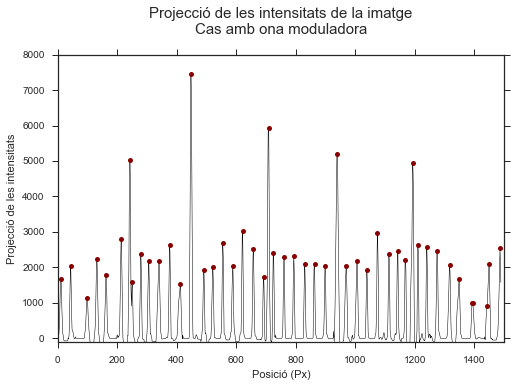

In [211]:
im = load_subImage(secondary_images['IMG'][8],
                   secondary_images['edges'][8])
mx, smth = find_maximum(im)

rg = np.array(range(len(smth)))

plt.plot(smth, lw=.5, c='black')
plt.plot(rg[1:-1][mx], smth[1:-1][mx],'.', color='#880000', ms=10)
plt.title(u"Projecció de les intensitats de la imatge\n"+
          u"Cas amb ona moduladora\n", fontsize = 15)
plt.xlabel(u"Posició (Px)")
plt.ylabel(u"Projecció de les intensitats")
plt.ylim([-100,8000])
plt.xlim(0,1500)
plt.subplots_adjust(top=0.85)
plt.savefig("OUT/FIG/point_detector_mult.png", dpi = 300)

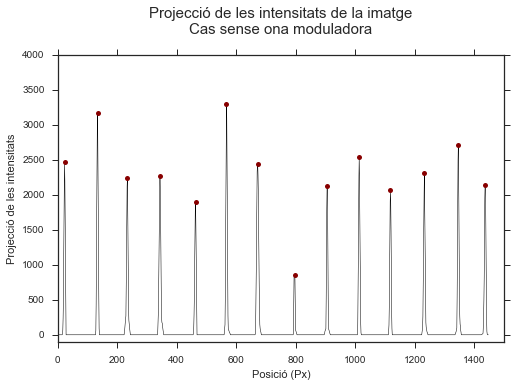

In [212]:
im = load_subImage(no_secondary_images['IMG'][2],
                   no_secondary_images['edges'][2])
mx, smth = find_maximum(im)

rg = np.array(range(len(smth)))

plt.plot(smth, lw=.5, c='black')
plt.plot(rg[1:-1][mx], smth[1:-1][mx],'.', color='#880000', ms=10)
plt.title(u"Projecció de les intensitats de la imatge\n"+
          u"Cas sense ona moduladora\n", fontsize = 15)
plt.xlabel(u"Posició (Px)")
plt.ylabel(u"Projecció de les intensitats")
plt.ylim([-100,4000])
plt.xlim(0,1500)
plt.subplots_adjust(top=0.85)
plt.savefig("OUT/FIG/point_detector_sing.png", dpi =300)

Ara que tenim la detecció dels màxims feta, queda una petita feina a fer per al cas en què hi hagi ona moduladora: Discriminar els punts referents a la ona moduladora dels referits a la ona modulada. Cal dissenyar, per tant, un algorisme per a fer-ho.

### Separació dels màxims en les imartges

Per a fer-ho, tal i com ens fa pensar la intuició, senzillament posarem un treshold, i agafarem les que siguin superiors al treshold.

La següent funció implementa aquest algoritme:

In [170]:
def separate_maximums(smth,mx, q=0.5):
    rmx = smth[1:-1][mx]
    m1 = np.sort(rmx)[-3]
    m2 = np.percentile(rmx, 75)
    treshold = m1*q+m2*(1-q)
    #treshold = m2
    return np.logical_and(mx,smth[1:-1]>treshold), np.logical_and(mx,smth[1:-1]<=treshold)

Mostrem ara el resultat de l'algorisme implementat per al mateix cas que estavem treballant:

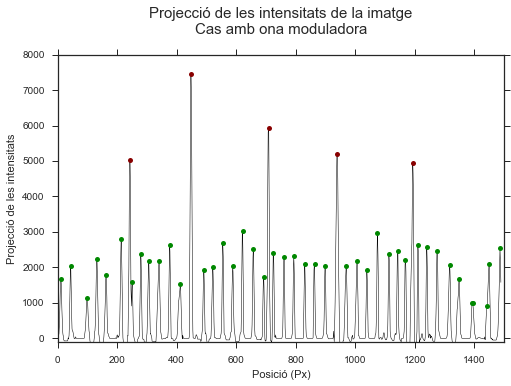

In [213]:
im = load_subImage(secondary_images['IMG'][8],
                   secondary_images['edges'][8])

mx, smth = find_maximum(im)

mx1, mx2 = separate_maximums(smth,mx)

rg = np.array(range(len(smth)))

plt.plot(smth, lw=.5, c='black')
plt.plot(rg[1:-1][mx1], smth[1:-1][mx1],'.', color='#880000', ms=10)
plt.plot(rg[1:-1][mx2], smth[1:-1][mx2],'.', color='#008800', ms=10)
plt.title(u"Projecció de les intensitats de la imatge\n"+
          u"Cas amb ona moduladora\n", fontsize = 15)
plt.xlabel(u"Posició (Px)")
plt.ylabel(u"Projecció de les intensitats")
plt.ylim([-100,8000])
plt.xlim(0,1500)
plt.subplots_adjust(top=0.85)
plt.savefig("OUT/FIG/point_detector_separator.png", dpi = 300)

### Càcul de les distàncies entre pics (en píxels)

Ara ens hem d'adonar d'un punt molt important a tenir en compte: les dades que hem trobat no son, ni de bon tros, perfectes. Per tant, no podem calcular la distància entre màxims fent diferència entre màxims consecutius, ja que el resultat fallarà bastant estrepitosament allà on tinguem màxims que sobrin/faltin. Per tant, haurem de reomplir els forats que faltin. Per a fer-ho, detectarem on falten punts, i assignarem a cada punt un index $k$, que ens digui quin punt seria si els tinguessim tots:

In [172]:
def find_real_point_position(positions):
    orders = range(len(positions))
    m = np.mean(np.diff(positions)/np.diff(orders))
    orders = np.cumsum(np.round(np.diff(positions)/m))
    orders = np.append((0),orders)
    return orders

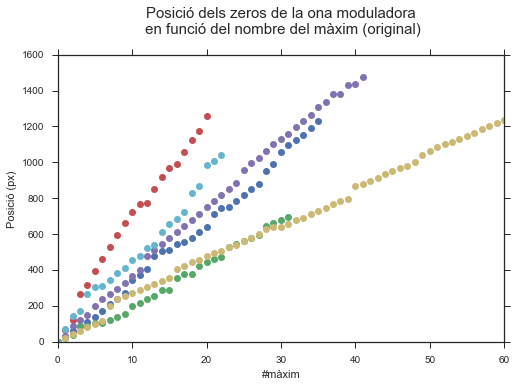

In [214]:
for im,edge in zip(secondary_images['IMG'],
                   secondary_images['edges'],):
    im = load_subImage(im,edge)
    mx, smth = find_maximum(im)
    mx1, mx2 = separate_maximums(smth,mx)
    rg = np.array(range(len(smth)))
    points_zero = rg[1:-1][mx2]
    plt.plot(points_zero-points_zero[0],'o')
    plt.title(u"Posició dels zeros de la ona moduladora\n"+
              u" en funció del nombre del"+
              u" màxim (original)\n", fontsize=15)
    plt.xlabel(u"#màxim")
    plt.ylabel(u"Posició (px)")
plt.subplots_adjust(top=0.85)
plt.savefig("OUT/FIG/zeros_before_filter.png", dpi = 300)

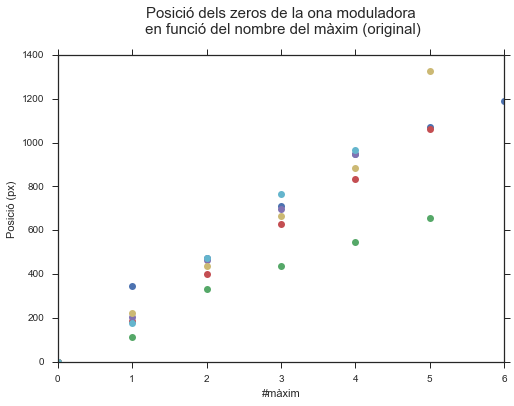

In [216]:
for im,edge in zip(secondary_images['IMG'],
                   secondary_images['edges'],):
    im = load_subImage(im,edge)
    mx, smth = find_maximum(im)
    mx1, mx2 = separate_maximums(smth,mx)
    rg = np.array(range(len(smth)))
    points_zero = rg[1:-1][mx1]
    plt.plot(points_zero-points_zero[0],'o')
    plt.title(u"Posició dels zeros de la ona moduladora\n"+
              u" en funció del nombre del"+
              u" màxim (original)\n", fontsize=15)
    plt.xlabel(u"#màxim")
    plt.ylabel(u"Posició (px)")

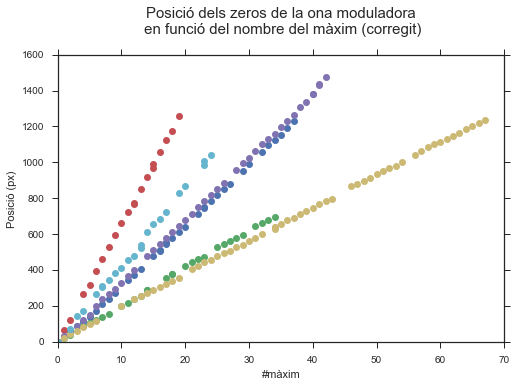

In [217]:
for im,edge in zip(secondary_images['IMG'],
                   secondary_images['edges'],):
    im = load_subImage(im,edge)
    mx, smth = find_maximum(im)
    mx1, mx2 = separate_maximums(smth,mx)
    rg = np.array(range(len(smth)))
    points_zero = rg[1:-1][mx2]
    positions = find_real_point_position(points_zero)
    plt.plot(positions,
             points_zero-points_zero[0],'o')
    plt.title(u"Posició dels zeros de la ona moduladora\n"+
              u" en funció del nombre del"+
              u" màxim (corregit)\n", fontsize=15)
    plt.xlabel(u"#màxim")
    plt.ylabel(u"Posició (px)")
plt.subplots_adjust(top=0.85)
plt.savefig("OUT/FIG/zeros_after_filter.png", dpi = 300)

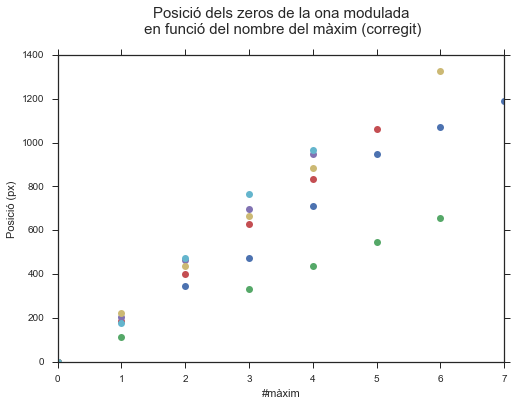

In [176]:
for im,edge in zip(secondary_images['IMG'],
                   secondary_images['edges'],):
    im = load_subImage(im,edge)
    mx, smth = find_maximum(im)
    mx1, mx2 = separate_maximums(smth,mx)
    rg = np.array(range(len(smth)))
    points_zero = rg[1:-1][mx1]
    positions = find_real_point_position(points_zero)
    plt.plot(positions,
             points_zero-points_zero[0],'o')
    plt.title(u"Posició dels zeros de la ona modulada\n"+
              u" en funció del nombre del"+
              u" màxim (corregit)\n", fontsize=15)
    plt.xlabel(u"#màxim")
    plt.ylabel(u"Posició (px)")

-----

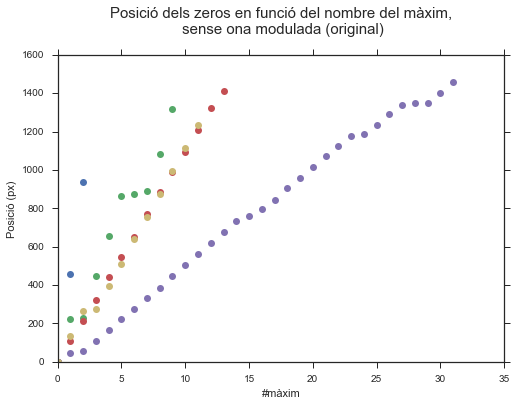

In [177]:
for im,edge in zip(no_secondary_images['IMG'],
                   no_secondary_images['edges'],):
    im = load_subImage(im,edge)
    mx, smth = find_maximum(im)
    rg = np.array(range(len(smth)))
    points_zero = rg[1:-1][mx]
    plt.plot(points_zero-points_zero[0],'o')
    plt.title(u"Posició dels zeros"+
              u" en funció del nombre del"+
              u" màxim,\n sense ona modulada (original)\n", fontsize=15)
    plt.xlabel(u"#màxim")
    plt.ylabel(u"Posició (px)")

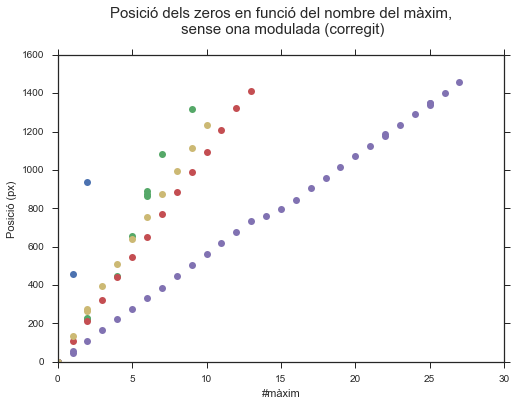

In [178]:
for im,edge in zip(no_secondary_images['IMG'],
                   no_secondary_images['edges'],):
    im = load_subImage(im,edge)
    mx, smth = find_maximum(im)
    rg = np.array(range(len(smth)))
    points_zero = rg[1:-1][mx]
    positions = find_real_point_position(points_zero)
    plt.plot(positions,
             points_zero-points_zero[0],'o')
    plt.title(u"Posició dels zeros"+
              u" en funció del nombre del"+
              u" màxim,\n sense ona modulada (corregit)\n", fontsize=15)

    plt.xlabel(u"#màxim")
    plt.ylabel(u"Posició (px)")

Ara podem utilitzar aquesta correcció que hem trobat per a estimar la distància entre màxims adequadament. Només cal recordar que si be en mesures físiques s'acostuma a utilitzar la mitjana i la desviació estàndard com a estimadors del valor i la seva possible fluctuació, en mesures de processament d'imatge no és així. Cal utilitzar esimadors més robustos, que tinguin en compte que un cert percentatge de les dades pot ser senzillament erroni, i no aportar cap informació útil. Els estimadors a utilitzar en aquests casos són la mediana i la median absolute deviation. Sabent això, procedim a calcular els estimadors dels paràmetres:

In [179]:
modulated = unp.uarray(np.zeros(11),0)
modulator = unp.uarray(np.zeros(11),0)

for k in range(11):
    im = load_subImage(data['IMG'][k], data['edges'][k])
    mx, smth = find_maximum(im)
    mx1, mx2 = separate_maximums(smth,mx)
    rg = np.array(range(len(smth)))
    
    if data['N'][k]>1:
        mx=mx1
        points_zero = rg[1:-1][mx2]
        positions = find_real_point_position(points_zero)
        deltaN = np.diff(positions)
        deltaP = np.diff(rg[1:-1][mx2])
        delta = deltaP[deltaN>0]/deltaN[deltaN>0]
        med = np.median(delta)
        mad = np.median(np.abs(delta-med))
        modulated[k]=uc.ufloat(med,mad/np.sqrt(len(delta)))
    
    points_zero = rg[1:-1][mx]
    positions = find_real_point_position(points_zero)
    deltaN = np.diff(positions)
    deltaP = np.diff(rg[1:-1][mx])
    delta = deltaP[deltaN>0]/deltaN[deltaN>0]
    med = np.median(delta)
    mad = np.median(np.abs(delta-med))
    modulator[k]=uc.ufloat(med,mad/np.sqrt(len(delta)))

Els resultats que hem trobat els mostrarem més endavant, en una taula completa que ens mostri tots els càlculs fets.

### Transformació de les dades a mm

Ara, hem de transformar els resultats que hem trobat en píxels a milímetres. Per a fer això hem de calcular la distància entre dos punts a distància coneguda en la imatge. Hem escollit dos extrems de la zona milimetrada, que té $280$ mm de longitud. Amb els píxels trobats, les ratios associades són:

In [180]:
ratios = {1:(1547 - 47)/uc.ufloat(280,2), 
          2:(1550 - 45)/uc.ufloat(280,2)}

Ara apliquem les ratios que hem trobat a cada mesura:

In [181]:
ratio_list = [ratios[k] for k in data['IMG']]
modulated/=ratio_list
modulator/=ratio_list

In [182]:
data['modulated'] = modulated
data['modulator'] = modulator

Potser, per altra banda, ja seria hora de començar a mostrar les dades que hem obtingut! [recordem que les dades modulades són en mm]

In [183]:
data

IMG   X0   Y0    X1    Y1  N  Size    Sep                      edges  \
0     2  237   50  1556   192  1  0.02  0.000   ((237, 50), (1556, 192))   
1     2  108  318  1556   409  1  0.04  0.000  ((108, 318), (1556, 409))   
2     2   93  460  1591   503  1  0.08  0.000   ((93, 460), (1591, 503))   
3     2   51  513  1591   594  1  0.16  0.000   ((51, 513), (1591, 594))   
4     2   51  630  1591   768  1  0.00  0.000   ((51, 630), (1591, 768))   
5     1  200  138  1566   290  2  0.08  0.260  ((200, 138), (1566, 290))   
6     1  394  326  1245   428  2  0.08  0.500  ((394, 326), (1245, 428))   
7     1  204  498  1522   570  2  0.04  0.125  ((204, 498), (1522, 570))   
8     2   51  777  1591   862  2  0.04  0.250   ((51, 777), (1591, 862))   
9     2   51  900  1591  1070  2  0.04  0.500  ((51, 900), (1591, 1070))   
10    1  324  674  1534   744  3  0.04  0.250  ((324, 674), (1534, 744))   

       modulated     modulator  
0        0.0+/-0    87.3+/-1.6  
1        0.0+/-0    29.0+/-3.4  
2        0.0+/-0  20.47+/-0.30  
3        0.0+/-0  10.05+/-0.16  
4        0.0+/-0  22.33+/-0.28  
5    6.16+/-0.09    28.2+/-2.4  
6    3.36+/-0.11  20.72+/-0.15  
7   12.69+/-0.21    39.8+/-1.1  
8    6.51+/-0.08    45.0+/-1.5  
9    3.35+/-0.05  41.12+/-0.31  
10   7.53+/-0.25        46+/-4

## Anàlisi de les dades obtingudes

Ara que ja tenim les dades, podem començar a comprovar les formules donades al guió. Podem calcular els angles associats als desplaçaments estudiats, tant des d'un punt de vista teòric, a partir de les mides, com a partir dels desplaçaments, per a observar si són coherents:

In [184]:
distance = uc.ufloat(2740,20) #distància a la paret

In [185]:
theta_modulated = modulated/distance
theta_modulator = modulator/distance

Començarem per la ona moduladora (la generada per les escletxes i no per la interacció entre escletxes)

Ara si recordem les formules del guió, tenim que la intensitat en funció de la posició és:

\begin{equation}
I(\theta) = I_0 \left ( \frac {\sin \beta}{\beta}\right ) ^2
\end{equation}

on $\beta = k \frac b 2 sin \theta$

Per tant, la intensitat s'anul·la si:

\begin{equation}
k \frac b 2 sin \theta =  \pi n
\end{equation}

En aproximaciò paraxial, ho podem escriure com:

\begin{equation}
\theta = \frac {2 \pi}{b k} n
\end{equation}

i per tant $\Delta \theta = \frac {2 \pi}{b k} = \frac{\lambda}{b}$

Si recordem que teníem un laser He-Ne:

In [186]:
lamb_HeNe = 633E-6 #en mm

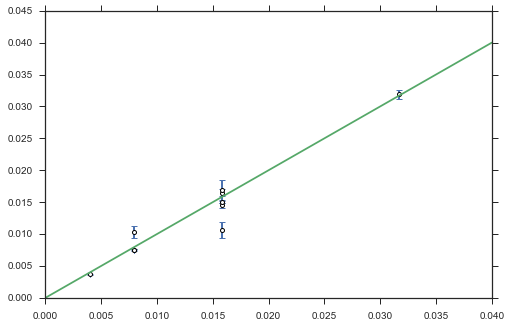

In [218]:
plt.errorScatter( lamb_HeNe/data['Size'], theta_modulator)
plt.plot([0,0.04],[0,0.04])
plt.xlim([0,0.04])
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(top=0.85)
plt.savefig("OUT/FIG/calculated_vs_nominal.png", dpi = 300)

In [189]:
#############^^^^^ACABAR^^^^^^##############

# Anàlisi d'imatges

Mentre erem al laboratori vàrem prendre diverses imatges, de les quals hem pogut extreure informació quantitativa, a partir de l'estudi de les imatges

## Anàlisi de la forma dels pics d'intensitat

Un dels anàlisis més immediats és el de comprovar la forma de la intensitat dels màxims en una difracció amb una escletxa. Per a fer-ho, hem seguit el mateix procediment que abans. Hem fet una fotografia al patró del laboratori, i ens hem restringit a la franja horizontal on es veu el patró:

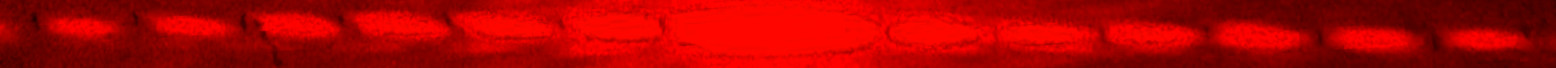

In [190]:
img = Image.open('IN/IMG/single_slit_intensity.jpg')
img

Una vegada hem carregat aquesta imatge, seguim el procediment anterior de sumar la intensitat de totes les rectes verticals, "projectant" les intensitats sobre l'eix horizontal. Aquest resultat ara, semblaria que l'hem de representar contra la funció `sinc`, ja que és el que diu la formula trobada a classe. Fer-ho així seria desastrós.

Cal tenir en compte, per a que funcioni, un fenòmen important en les càmeres fotogràfiques digitals: La intensitat guardada en `RGB`en memòria no és proporcional al nombre de fotons, si no que pateix un preprocessament important. Aquest preprocessament entre d'altres coses, acostuma a incloure una transformació logarítmica de les dades amb alta intensitat. Per tant, el que cal representar no és les dades contra el `sinc`, si no contra el seu logaritme.

Fem, per tant, el que hem comentat:

In [191]:
npa = np.asarray(img)[:,:,0]
k = np.sum(npa, axis=0)

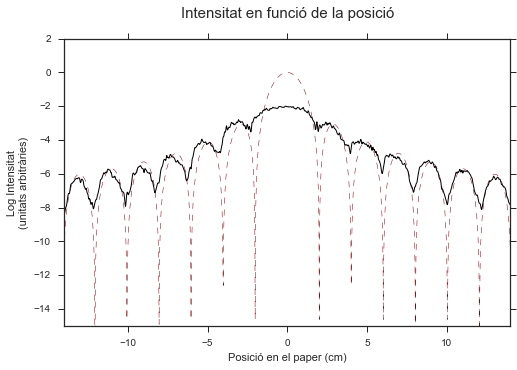

In [219]:
x=np.linspace(-15,15,1500)
px=30./1600*np.array(range(len(k)))-14.5

plt.title(u'Intensitat en funció de la posició\n', fontsize = 15)
plt.ylabel(u'Log Intensitat\n(unitats arbitràries)')
plt.xlabel(u'Posició en el paper (cm)')

nk=np.convolve(k, np.ones((3,))/3, mode='same')
nk = nk/max(nk)*1.01

plt.plot(x, np.log(np.sinc(x/2.01)**2),'--', c='#880000', lw=0.5 )
plt.plot(px-.2,(nk-1.21)*10+0.03*px, c='k', label ='Valor mesurat', lw=1)

plt.ylim(-15,2)
plt.xlim(-14,14)

plt.subplots_adjust(top=0.85)
plt.savefig("OUT/FIG/intensity_from_phone.png", dpi = 300)

## Anàlisi de la xarxa hexagonal

Más difícil todavía.... Agafarem una imatge d'un patró de difracció fet per una xarxa de difracció hexagonal, i intentarem recuperar-ne la xarxa fent la transformada de fourier inversa de la imatge. A l'esquerra mostrem la imatge, i a la dreta, la seva transformada de fourier. Seguint la filosofia d'abans, hem hagut de calcular la exponencial de la imatge, per a contrarrestar el preprocessament.

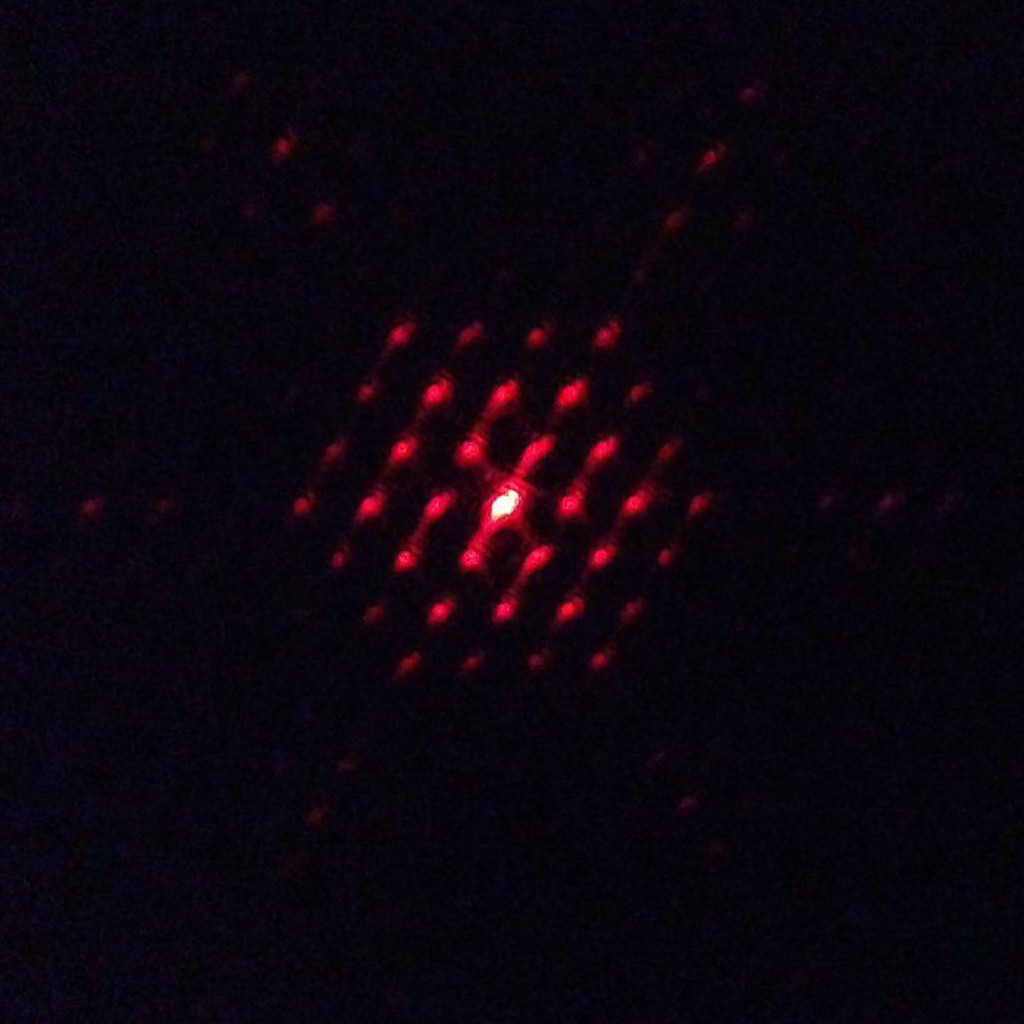

In [221]:
img = Image.open('IN/IMG/hex.jpg')
img

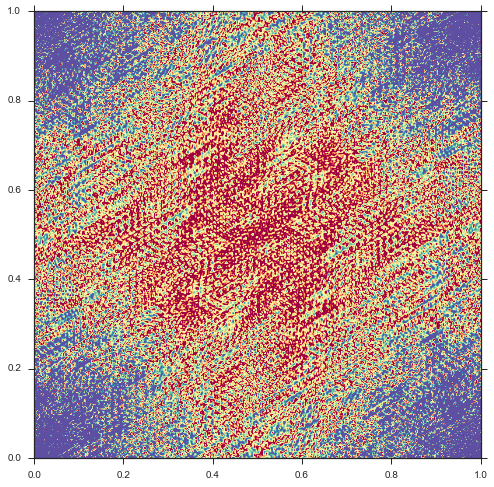

In [222]:
plt.figure(figsize=(8,8))
im = np.asarray(img)[:,:,0]
im=np.exp(im/25)
s=(np.log(np.abs(np.fft.fft2(im))))
plt.imshow(s[::-1], norm=LogNorm(vmin=11.5, vmax=13),extent = [0,1,0,1],cmap="Spectral")

En la imatge de la transformada de fourier es pot intuir en algunes zones una xarxa, i per les direccions de les línies, podria semblar que hexagonal i tot. Ara bé, cal una mirada molt més propera al patró de difracció per a poder veure realment la existència, en alguns trossos, d'aquesta xarxa hexagonal:

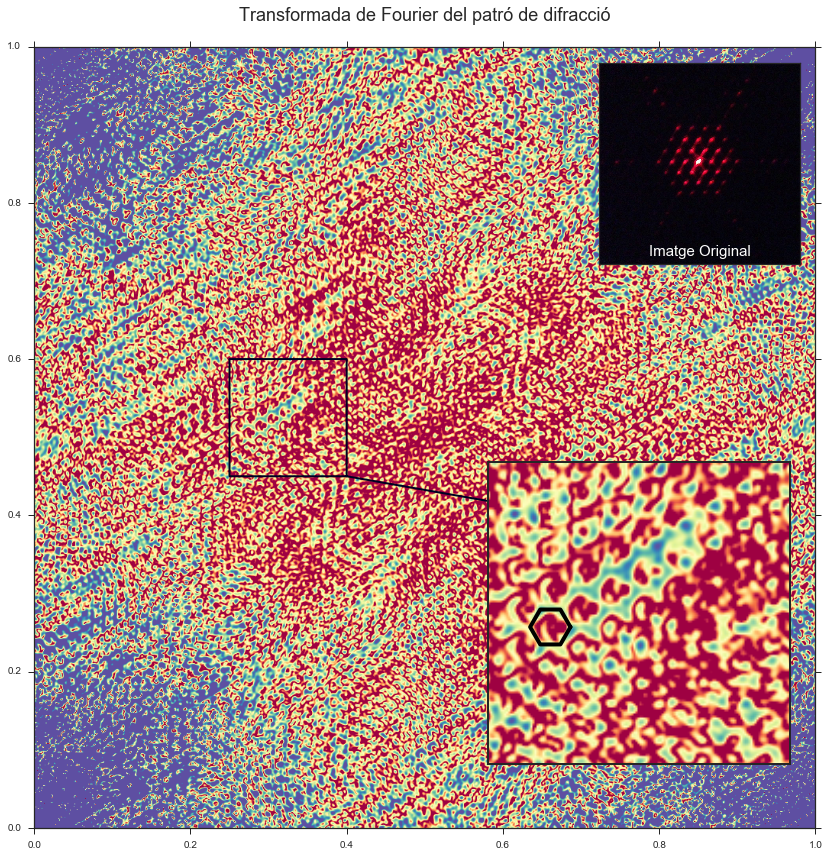

In [226]:
def hex(r,theta):
    t = 2*3.141592*np.array(range(7))/6+theta
    return r*np.cos(t), r*np.sin(t)

fig1 = plt.figure(figsize=(14,16))
ax1 = fig1.add_subplot(111)
cm="Spectral"
s=(np.log(np.abs(np.fft.fft2(im))))
ax1.imshow(s[::-1], norm=LogNorm(vmin=11.5, vmax=13),extent = [0,1,0,1],cmap=cm)
plt.title(u'Transformada de Fourier del patró de difracció\n', fontsize = 18)
# add a line
ax1.plot([.4  , .4, .25,.25,.4,.6], 
         [0.45, .6, .6,.45,.45,.415], c='#000022', lw=2)
plt.xlim(0,1)
plt.ylim(0,1)

s=(np.log(np.abs(np.fft.fft2(im))))[450:600,250:400]
ax2 = plt.axes([.575, .185, .3, .3], axisbg='y')
ax2.imshow(s[::-1], norm=LogNorm(vmin=11.5, vmax=13),extent = [0.25,0.4,0.45,0.6,],cmap=cm)
ax2.set_xlim([0.25,0.4])
ax2.set_ylim([0.45,0.6,])
x,y = hex(0.01,0)
ax2.plot(x+0.281,y+0.518,lw=4, alpha = 1, c='k')
#ax2.plot([.3  , .4, .25,.25,.4,.6], 
#         [0.5, .6, .6,.45,.45,.415], c='#000022', lw=2)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(2)
plt.setp(ax2, xticks=[], yticks=[])



ax3 = plt.axes([.685, .625, .2, .2], axisbg='y')
ax3.set_xlabel('Imatge Original', color='w', labelpad=-20, fontsize = 15)
ax3.imshow(img)
plt.setp(ax3, xticks=[], yticks=[])
plt.subplots_adjust(top=0.85)
plt.savefig("OUT/FIG/big_fft_image.png", dpi = 300)

In [201]:
f = lambda x:'${:L}$'.format(x) if x.s!=0 else "--"
F = lambda x:  map(f, x)

h = lambda x: str(x) if x>0 else "--"
H = lambda x:  map(h, x)

theta_modulator[theta_modulator==0] = uc.ufloat(1E20,0)
theta_modulated[theta_modulated==0] = uc.ufloat(1E20,0)
r1 = pd.DataFrame({"d"              : H(data["Size"]),
                   "sep"            : H(data["Sep"]), 
                   "modulatorl"     : F(modulator),
                   "modulatortheta" : F(theta_modulator), 
                   "modulatedl"     : F(modulated),
                   "modulatedtheta" : F(theta_modulated), 
                   "calculatedsep"  : F(lamb_HeNe/theta_modulated),
                   "calculatedd"    : F(lamb_HeNe/theta_modulator),
                   "N"              : H(data["N"])
                  })
r1.to_csv("OUT/TBL/output.csv")

In [200]:
r1


N          calculatedd        calculatedsep     d        modulatedl  \
0   1  $0.0199 \pm 0.0004$                   --  0.02                --   
1   1    $0.060 \pm 0.007$                   --  0.04                --   
2   1  $0.0848 \pm 0.0014$                   --  0.08                --   
3   1  $0.1726 \pm 0.0030$                   --  0.16                --   
4   1  $0.0777 \pm 0.0011$                   --    --                --   
5   2    $0.062 \pm 0.005$    $0.282 \pm 0.004$  0.08   $6.16 \pm 0.09$   
6   2  $0.0837 \pm 0.0009$    $0.516 \pm 0.017$  0.08   $3.36 \pm 0.11$   
7   2  $0.0436 \pm 0.0013$  $0.1366 \pm 0.0024$  0.04  $12.69 \pm 0.21$   
8   2  $0.0385 \pm 0.0013$    $0.266 \pm 0.004$  0.04   $6.51 \pm 0.08$   
9   2  $0.0422 \pm 0.0004$    $0.518 \pm 0.009$  0.04   $3.35 \pm 0.05$   
10  3  $0.0375 \pm 0.0035$    $0.230 \pm 0.008$  0.04   $7.53 \pm 0.25$   

             modulatedtheta        modulatorl         modulatortheta    sep  
0                        --    $87.3 \pm 1.6$    $0.0319 \pm 0.0006$     --  
1                        --    $29.0 \pm 3.4$    $0.0106 \pm 0.0013$     --  
2                        --  $20.47 \pm 0.30$  $0.00747 \pm 0.00012$     --  
3                        --  $10.05 \pm 0.16$  $0.00367 \pm 0.00006$     --  
4                        --  $22.33 \pm 0.28$  $0.00815 \pm 0.00012$     --  
5     $0.00225 \pm 0.00004$    $28.2 \pm 2.4$    $0.0103 \pm 0.0009$   0.26  
6     $0.00123 \pm 0.00004$  $20.72 \pm 0.15$  $0.00756 \pm 0.00008$    0.5  
7     $0.00463 \pm 0.00008$    $39.8 \pm 1.1$    $0.0145 \pm 0.0004$  0.125  
8   $0.002377 \pm 0.000033$    $45.0 \pm 1.5$    $0.0164 \pm 0.0006$   0.25  
9   $0.001222 \pm 0.000022$  $41.12 \pm 0.31$  $0.01501 \pm 0.00016$    0.5  
10    $0.00275 \pm 0.00009$        $46 \pm 4$    $0.0169 \pm 0.0016$   0.25